In [1]:
import sys
sys.path.append('../src')
from data import get_documents_list, get_data_and_labels_lists, get_sbert_models_path, get_languages
from models import classification
from sentence_transformers import SentenceTransformer
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


loaded spacy language model: en_core_web_sm


### Choose Parameters: 
- text_type = "cleaned_texts", "cleaned_sentences", "cleaned_paragraphs"
    -> text type for applying classification on
    
e.g. text_type = "cleaned_paragraphs", model = "distiluse-base-multilingual-cased-v1"

In [2]:
text_type = "cleaned_sentences"
model = "distiluse-base-multilingual-cased-v1"

https://www.sbert.net/docs/pretrained_models.html#multi-lingual-models

In [3]:
docs, targets = get_data_and_labels_lists(text_type)

In [4]:
languages_string =  "_".join(get_languages())
model_path = get_sbert_models_path().joinpath(f'st_{languages_string}_{text_type}_{model}.pkl')

In [5]:
try:
    #Load sentences & embeddings from disc
    with open(model_path, "rb") as fIn:
        stored_data = pickle.load(fIn)
        data = stored_data['data']
        embeddings = stored_data['data_embeddings']
        df = pd.DataFrame(list(zip(data, embeddings, targets)), columns =['data', 'data_embeddings', 'label'])
except FileNotFoundError as err:
    embedder = SentenceTransformer(model)
    df = pd.DataFrame(list(zip(docs, targets)), columns =['data', 'label'])
    df['data_embeddings'] = df['data'].apply(embedder.encode)
    embeddings = df['data_embeddings'].tolist()
    #Store sentences & embeddings on disc
    with open(model_path, "wb") as fOut:
        pickle.dump({'data': docs, 'data_embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
df

,data,label,data_embeddings
0,"[Abel, Ehrlich, , Hebrew, אבל, ארליך, Septemb...",0,"[[0.013540071, -0.02685532, -0.0390787, -0.029..."
1,"[ 1997, Ehrlich, win, Israel, Prize, Music]",0,"[[0.0010355223, 0.037810203, -0.01821833, 0.02..."
2,"[ Erlich, bear, 1915, Cranz, East, Prussia]",0,"[[-0.0194453, -0.03149785, -0.019828642, -0.06..."
3,"[ 1934, family, flee, Nazi, Germany, Yugoslavi...",0,"[[-0.029809302, 0.008181751, -0.064801306, 0.0..."
4,"[ leave, Yugoslavia, 1939, short, stay, Albani...",0,"[[0.03900471, -0.020451514, -0.04923513, -0.04..."
...,...,...,...
4853,"[ 1954, begin, teach, Meistersinger, Konservat...",1,"[[-0.05685312, -0.009760375, -0.06519614, 0.02..."
4854,"[ married, actress, Sabine, Peters]",1,"[[0.012596954, 0.012923361, -0.066175215, -0.0..."
4855,"[ Domgraf, Fassbaender, beautiful, voice, use,...",1,"[[-0.0012251915, 0.087526046, -0.00951335, 0.0..."
4856,"[ accomplished, singer, actor, well, appear, m...",1,"[[-0.047071923, 0.017807877, -0.067528665, 9.0..."


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['data_embeddings'], df['label'], test_size=0.2)

In [8]:
X_train_vect_avg = classification.average_text_vector(X_train)
X_test_vect_avg = classification.average_text_vector(X_test)

In [9]:
resampling = True

CLASSIFICATION WITH:OVERSAMPLING
0    3173
1    3173
Name: label, dtype: int64
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.65      0.86      0.74       601
    begnadet       0.54      0.27      0.36       371

    accuracy                           0.63       972
   macro avg       0.60      0.56      0.55       972
weighted avg       0.61      0.63      0.60       972

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing SVM Classification

              precision    recall  f1-score   support

    verfolgt       0.72      0.90      0.80       633
    begnadet       0.64      0.35      0.45       339

    accuracy                           0.70       972
   macro av

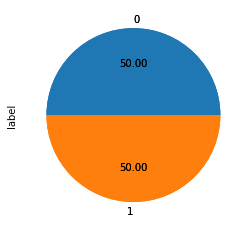

In [10]:
if not resampling:
    print("CLASSIFICATION WITHOUT SAMPLING:")
    #y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
    #classification.print_classification_report(y_test, y_pred)

    y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
    classification.print_classification_report(y_test, y_pred)

    y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
    classification.print_classification_report(y_test, y_pred)
    
    print(y_train.value_counts())
    y_train.value_counts().plot.pie(autopct='%0.2f')
    
else:
    ros = RandomOverSampler(sampling_strategy="not majority")
    rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
    
    for sampler, method in [(ros, "OVERSAMPLING"),(rus, "UNDERSAMPLING")]:
        print(f"CLASSIFICATION WITH:{method}")
            
        X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
        X_res, y_res = sampler.fit_resample(X_train_2d, y_train)
        
        print(y_res.value_counts())
        y_res.value_counts().plot.pie(autopct='%0.2f')
        
        #X_res revert 2_dimensionality
        X_res_1d = X_res.flatten()

        # classification with resampled vectors
        X_res_vect_avg = classification.average_text_vector(X_res_1d)

        #y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
        #classification.print_classification_report(y_test, y_res_pred)
        y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
        classification.print_classification_report(y_test, y_res_pred)
        y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
        classification.print_classification_report(y_test, y_res_pred)